In [1]:
from fastai2.vision.all import *
from siren import siren_model

In [52]:
# Optional dependency to visualize image gradient
import kornia

laplace_filter = partial(kornia.filters.laplacian, kernel_size=3)
gradient_filter = kornia.filters.sobel

def visualize_filter(image:TensorImage, filter_func):
    filt = filter_func(image.unsqueeze(0))
    # Normalizing to [0, 1] range
    filt -= filt.min()
    filt /= filt.max()
    plt.imshow(kornia.tensor_to_image(filt[0]))
    plt.axis(False)
    plt.show()
    
#Helper function
def decode_prediction(learner, inp):
    y_hat = learn.model(inp.cuda())
    return TensorImage(y_hat.transpose(0, 1).reshape(3, 256, 256))

# Visualizing the original image

In [3]:
pipe = Pipeline([PILImage.create, ToTensor, IntToFloatTensor, Resize(256)])
image = pipe("Samples/yorkshire_terrier_9.jpg")

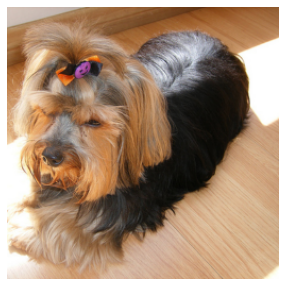

In [4]:
image.show();

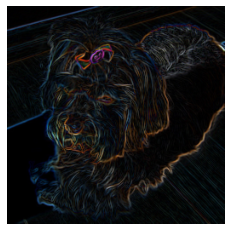

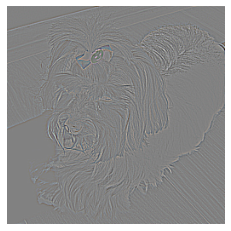

In [65]:
visualize_filter(image, gradient_filter)
visualize_filter(image, laplace_filter)

# Preparing the dataset

The first step is to reshape the image, so that each pixel will be a training example

In [5]:
y = image.reshape(3, -1).transpose(0, 1)
y.shape

torch.Size([65536, 3])

Then we create the coordinates that will be the input. According to the paper, they should be in the range [-1, 1], so we use meshgrid to create the coordinate pair (u, v) easily. In this case, the point (0, 0) represents the center of the image.

In [6]:
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/256), torch.arange(-1, 1, step=2/256)])
x = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim=1)
x = x.float()
x.shape

torch.Size([65536, 2])

Performing a quick check to make sure that the coordinates are correct

In [7]:
for coord, pixel_value in zip(x, y):
    c = ( 128 * (1 + coord)).long()
    assert (image[:, c[0], c[1]] == pixel_value).all(), "Pixel values do not match"

Now creating the dataset (image coordinates) -> (image pixel)

In [9]:
from torch.utils.data import TensorDataset, random_split
dset = TensorDataset(x.cuda(), y.cuda())

Random splitting the pixels so 20% of them are used for validation

In [14]:
val_pct = 0.2
val_len = int(len(dset)*val_pct)
lengths = [len(dset)-val_len, val_len]
train_dset, val_dset = random_split(dset, lengths)

In [15]:
dls = DataLoaders(DataLoader(train_dset, bs=256), DataLoader(val_dset, bs=4096))

# Creating the model, optimizer and loss

In [29]:
learn = Learner(dls, 
    siren_model([2, 256, 128, 64, 32, 3]).cuda(), 
    loss_func=MSELossFlat(),
    opt_func=ranger
    )

In [24]:
learn.model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Siren(w0=30)
  )
  (1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Siren(w0=1)
  )
  (2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Siren(w0=1)
  )
  (3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Siren(w0=1)
  )
  (4): Sequential(
    (0): Linear(in_features=32, out_features=3, bias=True)
    (1): Siren(w0=1)
  )
)

# Starting the training

In [32]:
learn.fit_flat_cos(5, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.106424,0.063525,00:01
1,0.026287,0.019503,00:01
2,0.009954,0.008522,00:01
3,0.005223,0.005035,00:01
4,0.003406,0.003785,00:01


This is the result after 5 epochs of training. You can already see the underlying image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


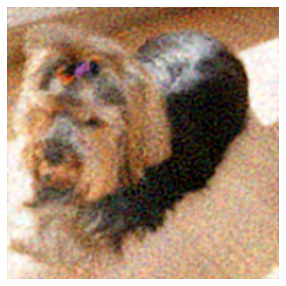

In [38]:
decode_prediction(learn, x).show();

Now the long training, so it captures the details

In [39]:
learn.fit_flat_cos(300, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.003141,0.003113,00:01
1,0.002489,0.002574,00:01
2,0.002132,0.002293,00:01
3,0.001905,0.002139,00:01
4,0.001751,0.002055,00:01
5,0.001634,0.002007,00:01
6,0.001539,0.001705,00:01
7,0.001460,0.001649,00:01
8,0.001396,0.001621,00:01
9,0.001345,0.001617,00:01


Visualizing the results of the training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


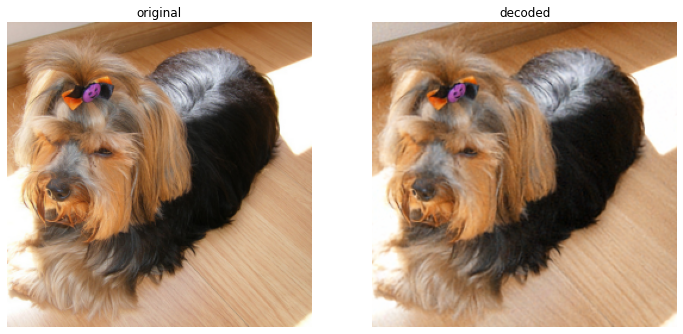

In [50]:
decoded = decode_prediction(learn, x)
_, ax = subplots(1, 2, figsize=(12, 20))
image.show(ax[0], title='original')
decoded.show(ax[1], title='decoded')

Visualizing the gradient and laplacian in the original image

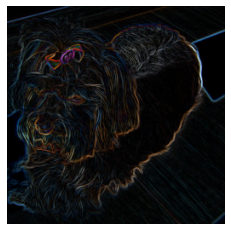

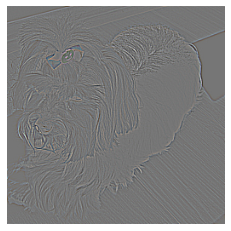

In [41]:
visualize_filter(image, gradient_filter)
visualize_filter(image, laplace_filter)

Visualizing the gradient and laplacian in the image created by the network

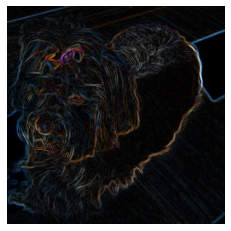

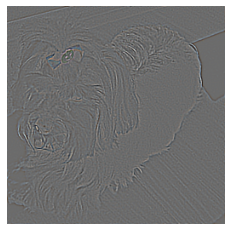

In [51]:
visualize_filter(decoded, gradient_filter)
visualize_filter(decoded, laplace_filter)

The following image was obtained after training with all of the pixels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


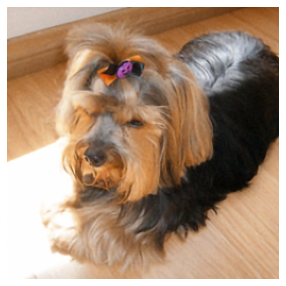

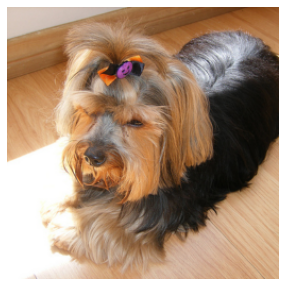

In [120]:
# Top one is from model, bottom is the original image
y_hat = learn.model(x.cuda())
TensorImage(y_hat.transpose(0, 1).reshape(3, 256, 256)).show()
image.show();

In [121]:
# Number of pixels on the image
256*256*3

196608

In [19]:
# Number of parameters on the model
sum([p.numel() for p in learn.model.parameters()])

44099

# Training a Relu model

In [54]:
from typing import List
def relu_model(dimensions: List[int]):
    """
        Sequence of linear layers followed by ReLU
    """
    layers = []
    for dim0, dim1 in zip(dimensions[:-1], dimensions[1:]):
        layers.append(nn.Linear(dim0, dim1))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [55]:
learn = Learner(dls, 
    relu_model([2, 256, 128, 64, 32, 3]).cuda(), 
    loss_func=MSELossFlat(),
    opt_func=ranger
    )

In [56]:
learn.model

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=3, bias=True)
  (9): ReLU()
)

In [58]:
learn.fit_flat_cos(5, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.108893,0.100766,00:01
1,0.030806,0.025684,00:01
2,0.017698,0.015642,00:01
3,0.013043,0.012221,00:01
4,0.011504,0.011389,00:01


This is the prediction of the ReLU model after the same 5 epochs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


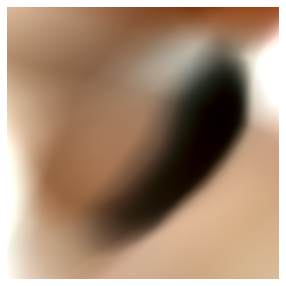

In [59]:
decode_prediction(learn, x).show()

In [60]:
learn.fit_flat_cos(300, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.011012,0.010453,00:01
1,0.010251,0.010003,00:01
2,0.009693,0.009349,00:01
3,0.009288,0.009056,00:01
4,0.008889,0.008774,00:01
5,0.008465,0.008226,00:01
6,0.008063,0.007584,00:01
7,0.007694,0.007295,00:01
8,0.007367,0.007057,00:01
9,0.007129,0.006907,00:01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


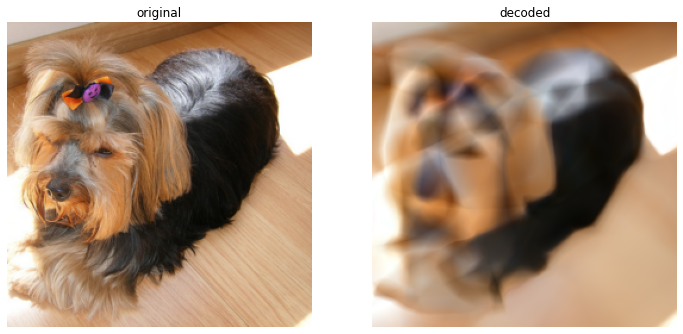

In [63]:
relu_pred = decode_prediction(learn, x)
_, ax = subplots(1, 2, figsize=(12, 20))
image.show(ax[0], title='original')
relu_pred.show(ax[1], title='decoded')

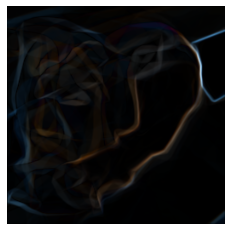

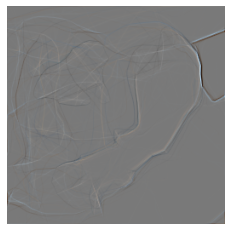

In [64]:
visualize_filter(relu_pred, gradient_filter)
visualize_filter(relu_pred, laplace_filter)